In [1]:
import itertools
import tqdm
import numpy as np
np.random.seed(12)

In [2]:
def ranking_score(tally_table, pair2row, ranking):
    sum_val = 0
    for i in range(len(ranking)-1):
        for j in range(i+1, len(ranking)):
            a = ranking[i]
            b = ranking[j]
            if a > b:
                row = pair2row[(b, a)]
                sum_val += tally_table[row, 2]
            else:
                row = pair2row[(a, b)]
                sum_val += tally_table[row, 0]
    return sum_val


def kemeny_young(data):
    num_experts, num_items = data.shape
    indices = np.arange(num_items)
    
    possible_pairs = list(itertools.combinations(indices, r=2))
    tally_table = np.zeros((len(possible_pairs), 3))
    pair2row = dict(zip(possible_pairs, range(len(possible_pairs))))
    
    for i in range(num_experts):
        expert_ranking = data[i]
        for i, (x, y) in enumerate(possible_pairs):
            rank_x = expert_ranking[x]
            rank_y = expert_ranking[y]
            if rank_x is None or rank_y is None:
                tally_table[i, 1] += 1
            elif rank_x > rank_y:
                tally_table[i, 2] += 1
            else:
                tally_table[i, 0] += 1
    #print(tally_table)
    
    possible_rankings = np.array(list(itertools.permutations(indices)))
    scores = [ranking_score(tally_table, pair2row, x) for x in possible_rankings]
    #print(list(zip(possible_rankings, scores)))
    return possible_rankings[np.argmax(scores)], (possible_pairs, tally_table, np.max(scores))

### Check 

In [3]:
# experts x food_items
# vals -- scores/ranks
data = [[1, 2, 3],
        [1, None, 2],
        [3, 1, 2],
        [None, None, 1],
        [3, 1, 2], 
        [3, 1, 2],
        [3, 1, 2]]

NUM_EXPERTS = 20
NUM_ITEMS = 5

data = np.stack([np.random.normal(0, 1, (NUM_ITEMS,)).argsort() for _ in range(NUM_EXPERTS)]).astype(object)
missing = np.random.binomial(1, 0.1, data.shape).astype(bool)
data[missing] = None

In [4]:
kemeny_young(np.array(data))

(array([1, 0, 2, 3, 4]),
 ([(0, 1),
   (0, 2),
   (0, 3),
   (0, 4),
   (1, 2),
   (1, 3),
   (1, 4),
   (2, 3),
   (2, 4),
   (3, 4)],
  array([[ 5.,  4., 11.],
         [ 7.,  6.,  7.],
         [ 6.,  9.,  5.],
         [10.,  4.,  6.],
         [11.,  3.,  6.],
         [10.,  6.,  4.],
         [13.,  1.,  6.],
         [ 9.,  5.,  6.],
         [12.,  3.,  5.],
         [ 7.,  6.,  7.]]),
  96.0))

### Sufficient expert number selection

In [5]:
NUM_EXPERTS = 500
NUM_ITEMS = 5

raw_data = np.stack([np.random.normal(i, 4, (NUM_EXPERTS,)) for i in range(NUM_ITEMS)]).T.astype(object)
data = raw_data.argsort(axis=1).astype(object)
missing = np.random.binomial(1, 0.1, data.shape).astype(bool)
raw_data[missing] = None
data[missing] = None

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

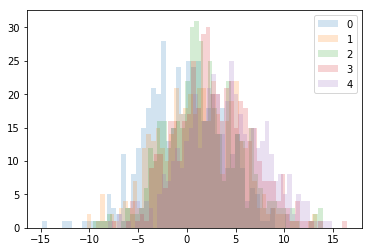

In [7]:
for i in range(NUM_ITEMS):
    item = raw_data[:,i]
    plt.hist(item[item != None].tolist(), alpha=0.2, label=str(i), bins=50)
plt.legend();

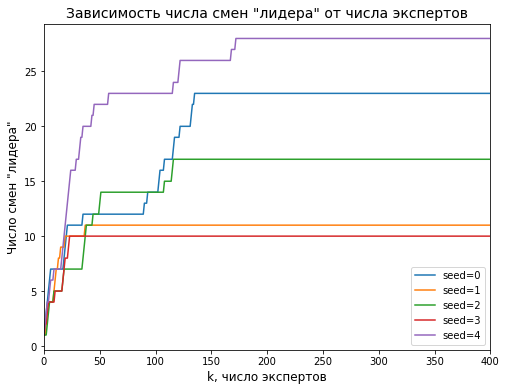

In [8]:
num_runs = 5
fig = plt.figure(figsize=(8, 6))
for seed in range(num_runs):
    raw_data = np.stack([np.random.normal(i, 4, (NUM_EXPERTS,)) for i in range(NUM_ITEMS)]).T.astype(object)
    data = raw_data.argsort(axis=1).astype(object)
    missing = np.random.binomial(1, 0.1, data.shape).astype(bool)
    raw_data[missing] = None
    data[missing] = None

    num_switch = 0
    leader_switch = []
    prev_res = np.array([0, 1, 2, 3, 4])
    for size in range(1, NUM_EXPERTS):
        res, table = kemeny_young(data[:size])
        num_switch += int(np.any(res != prev_res))
        leader_switch.append(num_switch)
        prev_res = res
    
    plt.plot(leader_switch, label='seed=%d'%seed)
    plt.xlim((0, 400))

plt.title('Зависимость числа смен "лидера" от числа экспертов', fontsize=14)
plt.xlabel("k, число экспертов", fontsize=12)
plt.ylabel('Число смен "лидера"', fontsize=12)
plt.legend();

In [9]:
fig.savefig('leader_changes.jpg')

### Food ratings

In [10]:
product_names = np.array(['Устрицы',
                          'Арахиc соленый',
                          'Молоко',
                          'Макароны',
                          'Овсяное молоко',
                          'Шоколад',
                          'Сырок',
                          'Кефир',
                          'Гречневая крупа']
                        )

In [11]:
inp = '''4				9	5					3	9	7	6
2	6	4	8	7	4	3	3		4	6	3	4	2
5	1	5	5	4	3	8	4	2	3	5	5	6	
7	7	2	3	2	8	4	6	3	5		6	5	1
	2	7	2	6	7	5	5	7		7	7	8	
3	4	1	9	5		1	1	6	6	1	2	2	4
	3	3		1	2	6	2	1	1	2	8		5
6	5	8	4	8	1	7	7	4	7		1	1	
1	8	6	1	3	6	2	8	5	2	4	4	3	3'''

data = np.array([line.split('\t') for line in inp.split('\n')]).astype(object)
data[data!=''] = data[data!=''].astype(int)
data[data==''] = None

In [12]:
data.shape

(9, 14)

In [13]:
argsort, (pairs, tally_table, _) = kemeny_young(data.T)
product_names[argsort]

array(['Шоколад', 'Сырок', 'Гречневая крупа', 'Арахиc соленый', 'Молоко',
       'Макароны', 'Овсяное молоко', 'Кефир', 'Устрицы'], dtype='<U15')

In [14]:
argsort

array([5, 6, 8, 1, 2, 3, 4, 7, 0])

In [15]:
for i in range(len(pairs)):
    print(pairs[i], tally_table[i])

(0, 1) [1. 7. 6.]
(0, 2) [2. 8. 4.]
(0, 3) [2. 8. 4.]
(0, 4) [3. 9. 2.]
(0, 5) [0. 8. 6.]
(0, 6) [0. 9. 5.]
(0, 7) [1. 9. 4.]
(0, 8) [2. 7. 5.]
(1, 2) [6. 2. 6.]
(1, 3) [8. 2. 4.]
(1, 4) [7. 4. 3.]
(1, 5) [4. 2. 8.]
(1, 6) [3. 4. 7.]
(1, 7) [6. 3. 5.]
(1, 8) [6. 1. 7.]
(2, 3) [7. 2. 5.]
(2, 4) [9. 3. 2.]
(2, 5) [5. 2. 7.]
(2, 6) [2. 4. 8.]
(2, 7) [7. 2. 5.]
(2, 8) [5. 1. 8.]
(3, 4) [6. 4. 4.]
(3, 5) [5. 2. 7.]
(3, 6) [4. 4. 6.]
(3, 7) [7. 2. 5.]
(3, 8) [6. 1. 7.]
(4, 5) [2. 4. 8.]
(4, 6) [3. 5. 6.]
(4, 7) [6. 4. 4.]
(4, 8) [2. 3. 9.]
(5, 6) [6. 4. 4.]
(5, 7) [7. 3. 4.]
(5, 8) [7. 1. 6.]
(6, 7) [7. 5. 2.]
(6, 8) [8. 3. 3.]
(7, 8) [6. 2. 6.]


### Comparison

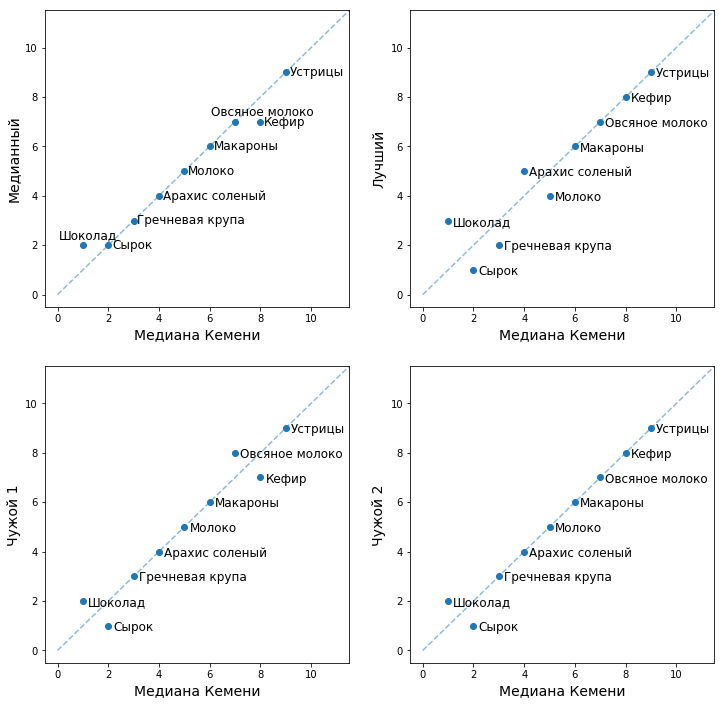

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
 
my_rating = [9, 4, 5, 6, 7, 1, 2, 8, 3]

best_rating = [9, 5, 4, 6, 7, 3, 1, 8, 2] # Slava
rating1 = [9, 4, 5, 6, 8, 2, 1, 7, 3] # Natalia
rating2 = [9, 4, 5, 6, 7, 2, 1, 8, 3] # Petr
#rating3 = [9, 3, 8, 4, 5, 1, 6, 7, 2] # 
mean_rating = [8.470588235, 4.705882353, 4.529411765, 5.294117647, 6.823529412,\
               2.470588235, 2.235294118, 6.588235294, 4.058823529]
median_rating = [9, 4, 5, 6, 7, 2, 2, 7, 3]
 
axs[0, 0].scatter(my_rating, median_rating)
axs[0, 0].plot([0, 12], [0, 12], '--', alpha=0.5)
axs[0, 0].set_ylabel('Медианный', fontsize=14)
axs[0, 0].set_xlabel('Медиана Кемени', fontsize=14)
 
axs[0, 1].scatter(my_rating, best_rating)
axs[0, 1].plot([0, 12], [0, 12], '--', alpha=0.5)
axs[0, 1].set_ylabel('Лучший', fontsize=14)
axs[0, 1].set_xlabel('Медиана Кемени', fontsize=14)
 
axs[1, 0].scatter(my_rating, rating1)
axs[1, 0].plot([0, 12], [0, 12], '--', alpha=0.5)
axs[1, 0].set_ylabel('Чужой 1', fontsize=14)
axs[1, 0].set_xlabel('Медиана Кемени', fontsize=14)
 
axs[1, 1].scatter(my_rating, rating2)
axs[1, 1].plot([0, 12], [0, 12], '--', alpha=0.5)
axs[1, 1].set_ylabel('Чужой 2', fontsize=14)
axs[1, 1].set_xlabel('Медиана Кемени', fontsize=14)

for ax in axs.ravel():
    ax.set_xlim((-0.5, 11.5))
    ax.set_ylim((-0.5, 11.5))

for i, x in enumerate(product_names):
    if i in [4, 5]:
        axs[0, 0].annotate(x, (my_rating[i]-0.95, median_rating[i]+0.25), fontsize=12)
    else:
        axs[0, 0].annotate(x, (my_rating[i]+0.15, median_rating[i]-0.15), fontsize=12)
    axs[0, 1].annotate(x, (my_rating[i]+0.2, best_rating[i]-0.2), fontsize=12)
    axs[1, 0].annotate(x, (my_rating[i]+0.2, rating1[i]-0.2), fontsize=12)
    axs[1, 1].annotate(x, (my_rating[i]+0.2, rating2[i]-0.2), fontsize=12)

plt.show();

In [63]:
fig.savefig('rating_comparison.jpg')